In [1]:
import sys
import os
import requests
import torchaudio
from torchaudio.compliance import kaldi
import numpy as npx
import torch
import matplotlib.pyplot as plt
from PIL import Image
sys.path.append("../")
import models_mae
import librosa
import librosa.display

### Define utils

In [3]:
MELBINS=128
TARGET_LEN=1024

In [4]:
# define the utils
def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)(in_chans=1, audio_exp=True,img_size=(TARGET_LEN,MELBINS),decoder_mode=1, decoder_depth=16)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model


In [5]:
NORM_MEAN = -9.821708
NORM_STD = 4.3084574

def wav2fbank(filename):

    waveform, sr = torchaudio.load(filename)
    waveform = waveform - waveform.mean()

    # 498 128
    fbank = kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False, 
                        window_type='hanning', num_mel_bins=MELBINS, dither=0.0, frame_shift=10)
    # AudioSet: 1024 (16K sr)
    # ESC: 512 (8K sr)
    n_frames = fbank.shape[0]
    p = TARGET_LEN - n_frames
    # cut and pad
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:TARGET_LEN, :]
    return fbank
def norm_fbank(fbank):
    norm_mean= NORM_MEAN
    norm_std= NORM_STD
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank

In [6]:
def display_fbank(bank, minmin=None, maxmax=None):
    #print(bank.shape, bank.min(), bank.max())
    #plt.figure(figsize=(18, 6))
    plt.figure(figsize=(20, 4))
    plt.imshow(20*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')
    #plt.colorbar()
    #S_db = librosa.amplitude_to_db(np.abs(bank.T.numpy()),ref=np.max)
    #S_db = bank.T.numpy()
    #plt.figure()
    #librosa.display.specshow(10*bank.T.numpy())
    #plt.colorbar()

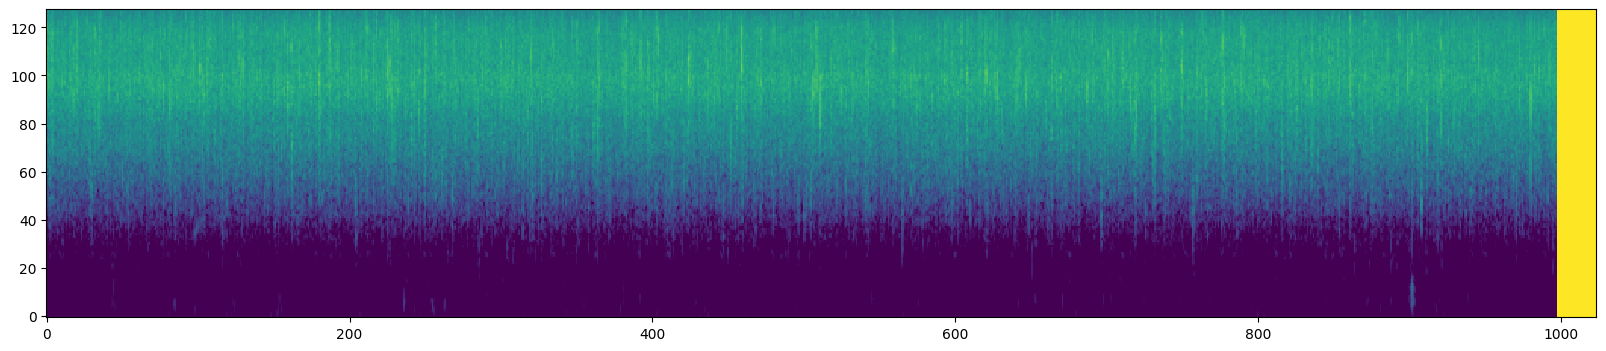

In [7]:
# wav_file = '/large_experiments/cmd/audioset/balance_wav/zye7IPXojSc.wav'
wav_file = '/mnt/data/tungtran/data/coral_chorus/OffReef_rawaudio_split/1677996071.170728031921_chunk_4.wav'
#wav_file = '/large_experiments/cmd/audioset/balance_wav/1JmYeNQ1jEI.wav'
fbank = wav2fbank(wav_file)
fbank = norm_fbank(fbank)
display_fbank(fbank)

### Load model

In [8]:
#chkpt_dir = '/checkpoint/berniehuang/experiments/53417041/checkpoint-80.pth'
# chkpt_dir = '/checkpoint/berniehuang/experiments/53636601/checkpoint-19.pth'
chkpt_dir = '/mnt/data/tungtran/AudioMAE/logs/output_dir_australia/checkpoint-32.pth'
model = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')

/home/pythonuser/py_env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>
Model loaded.


### Dataset class

In [9]:
import csv, os, sys
import json
import torchaudio
import numpy as np
import torch
import torch.nn.functional
from torch.utils.data import Dataset, Sampler
from torch.utils.data import DistributedSampler, WeightedRandomSampler
import torch.distributed as dist
import random
import math
import librosa

def make_index_dict(label_csv):
    index_lookup = {}
    with open(label_csv, 'r') as f:
        csv_reader = csv.DictReader(f)
        line_count = 0
        for row in csv_reader:
            index_lookup[row['mid']] = row['index']
            line_count += 1
    return index_lookup


class AudiosetDataset(Dataset):
    def __init__(self, dataset_json_file, audio_conf, label_csv=None, use_fbank=False, fbank_dir=None, roll_mag_aug=False, load_video=False, mode='train'):
        """
        Dataset that manages audio recordings
        :param audio_conf: Dictionary containing the audio loading and preprocessing settings
        :param dataset_json_file
        """
        self.datapath = dataset_json_file
        with open(dataset_json_file, 'r') as fp:
            data_json = json.load(fp)
        self.use_fbank = use_fbank
        self.fbank_dir = fbank_dir

        self.data = data_json['data']
        self.audio_conf = audio_conf
        print('---------------the {:s} dataloader---------------'.format(self.audio_conf.get('mode')))
        if 'multilabel' in self.audio_conf.keys():
            self.multilabel = self.audio_conf['multilabel']
        else:
            self.multilabel = False
        print(f'multilabel: {self.multilabel}')
        self.melbins = self.audio_conf.get('num_mel_bins')
        self.freqm = self.audio_conf.get('freqm')
        self.timem = self.audio_conf.get('timem')
        print('using following mask: {:d} freq, {:d} time'.format(self.audio_conf.get('freqm'), self.audio_conf.get('timem')))
        self.mixup = self.audio_conf.get('mixup')
        print('using mix-up with rate {:f}'.format(self.mixup))
        self.dataset = self.audio_conf.get('dataset')
        self.norm_mean = self.audio_conf.get('mean')
        self.norm_std = self.audio_conf.get('std')
        print('Dataset: {}, mean {:.3f} and std {:.3f}'.format(self.dataset, self.norm_mean, self.norm_std))
        self.noise = self.audio_conf.get('noise')
        if self.noise == True:
            print('now use noise augmentation')
        self.index_dict = make_index_dict(label_csv)
        self.label_num = len(self.index_dict)
        self.roll_mag_aug=roll_mag_aug
        print(f'number of classes: {self.label_num}')
        print(f'size of dataset {self.__len__()}')


    def _roll_mag_aug(self, waveform):
        waveform=waveform.numpy()
        idx=np.random.randint(len(waveform))
        rolled_waveform=np.roll(waveform,idx)
        mag = np.random.beta(10, 10) + 0.5
        return torch.Tensor(rolled_waveform*mag)

    def _wav2fbank(self, filename, filename2=None):
        if filename2 == None:
            try:
                waveform, sr = torchaudio.load(filename)
            except RuntimeError as e:
                waveform, sr = librosa.load(filename, sr=None)
                waveform = torch.tensor(waveform).unsqueeze(0)
            waveform = waveform - waveform.mean()
            if self.roll_mag_aug:
                waveform = self._roll_mag_aug(waveform)
        # mixup
        else:
            waveform1, sr = torchaudio.load(filename)
            waveform2, _ = torchaudio.load(filename2)

            waveform1 = waveform1 - waveform1.mean()
            waveform2 = waveform2 - waveform2.mean()

            if self.roll_mag_aug:
                waveform1 = self._roll_mag_aug(waveform1)
                waveform2 = self._roll_mag_aug(waveform2)

            if waveform1.shape[1] != waveform2.shape[1]:
                if waveform1.shape[1] > waveform2.shape[1]:
                    # padding
                    temp_wav = torch.zeros(1, waveform1.shape[1])
                    temp_wav[0, 0:waveform2.shape[1]] = waveform2
                    waveform2 = temp_wav
                else:
                    # cutting
                    waveform2 = waveform2[0, 0:waveform1.shape[1]]

            # sample lambda from beta distribtion
            mix_lambda = np.random.beta(10, 10)

            mix_waveform = mix_lambda * waveform1 + (1 - mix_lambda) * waveform2
            waveform = mix_waveform - mix_waveform.mean()
        # 498 128, 998, 128
        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                  window_type='hanning', num_mel_bins=self.melbins, dither=0.0, frame_shift=10)
        # 512
        target_length = self.audio_conf.get('target_length')
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]

        if filename2 == None:
            return fbank, 0
        else:
            return fbank, mix_lambda


    def _fbank(self, filename, filename2=None):
        if filename2 == None:
            fn1 = os.path.join(self.fbank_dir, os.path.basename(filename).replace('.wav','.npy'))
            fbank = np.load(fn1)
            return torch.from_numpy(fbank), 0
        else:
            fn1 = os.path.join(self.fbank_dir, os.path.basename(filename).replace('.wav','.npy'))
            fn2 = os.path.join(self.fbank_dir, os.path.basename(filename2).replace('.wav','.npy'))
            # sample lambda from beta distribtion
            mix_lambda = np.random.beta(10, 10)
            fbank = mix_lambda * np.load(fn1) + (1-mix_lambda) * np.load(fn2)  
            return torch.from_numpy(fbank), mix_lambda

    def __getitem__(self, index):
        """
        returns: image, audio, nframes
        where image is a FloatTensor of size (3, H, W)
        audio is a FloatTensor of size (N_freq, N_frames) for spectrogram, or (N_frames) for waveform
        nframes is an integer
        """
        # do mix-up for this sample (controlled by the given mixup rate)
        if random.random() < self.mixup: # for audio_exp, when using mixup, assume multilabel
            datum = self.data[index]
            # find another sample to mix, also do balance sampling
            # sample the other sample from the multinomial distribution, will make the performance worse
            # mix_sample_idx = np.random.choice(len(self.data), p=self.sample_weight_file)
            # sample the other sample from the uniform distribution
            mix_sample_idx = random.randint(0, len(self.data)-1)
            mix_datum = self.data[mix_sample_idx]

            # get the mixed fbank
            if not self.use_fbank:
                fbank, mix_lambda = self._wav2fbank(datum['wav'], mix_datum['wav'])
            else:
                fbank, mix_lambda = self._fbank(datum['wav'], mix_datum['wav'])
            # initialize the label
            label_indices = np.zeros(self.label_num)
            # add sample 1 labels
            for label_str in datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] += mix_lambda
            # add sample 2 labels
            for label_str in mix_datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] += 1.0-mix_lambda
            label_indices = torch.FloatTensor(label_indices)
        # if not do mixup
        else:
            datum = self.data[index]
            label_indices = np.zeros(self.label_num)
            if not self.use_fbank:
                fbank, mix_lambda = self._wav2fbank(datum['wav'])
            else:
                fbank, mix_lambda = self._fbank(datum['wav'])
            try:
                for label_str in datum['labels'].split(','):
                    label_indices[int(self.index_dict[label_str])] = 1.0
            except:
                label_indices[int(self.index_dict[datum['labels']])] = 1.0

            if self.multilabel:
                label_indices = torch.FloatTensor(label_indices)
            else:
                # remark : for ft cross-ent
                label_indices = int(self.index_dict[datum['labels']])
        # SpecAug for training (not for eval)
        freqm = torchaudio.transforms.FrequencyMasking(self.freqm)
        timem = torchaudio.transforms.TimeMasking(self.timem)
        fbank = fbank.transpose(0,1).unsqueeze(0) # 1, 128, 1024 (...,freq,time)
        if self.freqm != 0:
            fbank = freqm(fbank)
        if self.timem != 0:
            fbank = timem(fbank) # (..., freq, time)
        fbank = torch.transpose(fbank.squeeze(), 0, 1) # time, freq
        fbank = (fbank - self.norm_mean) / (self.norm_std * 2)
        if self.noise == True: # default is false, true for spc
            fbank = fbank + torch.rand(fbank.shape[0], fbank.shape[1]) * np.random.rand() / 10
            fbank = torch.roll(fbank, np.random.randint(-10, 10), 0)
        # the output fbank shape is [time_frame_num, frequency_bins], e.g., [1024, 128]
        return fbank.unsqueeze(0), label_indices, datum['wav']

    def __len__(self):
        return len(self.data)

### Load data

In [10]:
x = torch.tensor(fbank)
print(x.shape)
# make it a batch-like
x = x.unsqueeze(dim=0)
x = x.unsqueeze(dim=0)
print(x.shape)
#x = torch.einsum('nhwc->nchw', x)

torch.Size([1024, 128])
torch.Size([1, 1, 1024, 128])


/tmp/ipykernel_785982/2277072120.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


In [25]:
# label_dct = {0:'Degraded', 1: 'Healthy', 2: 'Restored'}
label_dct = {0:'OffReef', 1: 'Cocoloba', 2: 'Tektite'}
# label_dct = {0:'Badi', 1: 'Salisi', 2: 'Bontosua'}
# label_dct = {0: 'L', 1: 'A', 2: 'F', 3: 'H', 4: 'K', 5: 'E', 6: 'G', 7: 'D', 8: 'I', 9: 'B', 10: 'J', 11: 'C'}

In [15]:
from dataclasses import dataclass

@dataclass
class Argument:
    dataset: str
    data_eval: str
    label_csv: str
    use_fbank: bool
    fbank_dir: str
    batch_size: int
    num_workers: int
    pin_mem: bool

args = Argument(
    # dataset='crs_indo',
    # data_eval='/mnt/data/tungtran/AudioMAE/dataset/coral_sound_indo_location_30min_few_shot/val.json',
    # label_csv='/mnt/data/tungtran/AudioMAE/dataset/coral_sound_indo_location_30min_few_shot/class_labels_indices.csv',
    # data_eval='/mnt/data/tungtran/AudioMAE/dataset/coral_sound_indo_health_30min_few_shot_v2/val.json',
    # label_csv='/mnt/data/tungtran/AudioMAE/dataset/coral_sound_indo_health_30min_few_shot_v2/class_labels_indices.csv',
    # data_eval='/mnt/data/tungtran/AudioMAE/dataset/coral_sound_coral_chorus_30min_few_shot/val.json',
    # label_csv='/mnt/data/tungtran/AudioMAE/dataset/coral_sound_coral_chorus_30min_few_shot/class_labels_indices.csv',
    dataset='australia',
    data_eval='/mnt/data/tungtran/AudioMAE/dataset/australia/train.json',
    label_csv='/mnt/data/tungtran/AudioMAE/dataset/australia/class_labels_indices.csv',
    use_fbank=False,
    fbank_dir='',
    batch_size=8,
    num_workers=4,
    pin_mem=True,
)

norm_stats = {'audioset':[-4.2677393, 4.5689974], 'esc50':[-6.6268077, 5.358466], 'speechcommands':[-6.845978, 5.5654526], 'crs': [-9.517333, 4.306908], 'fish_crs': [-9.441656, 4.2926426], 'crs_coral_chorus': [-9.894564, 4.1962166], 'crs_indo': [-9.148823, 4.4092674], 'watkins': [-3.0449798, 2.899524], 'dcase': [-10.242867, 2.4992578], 'hiceas': [-7.784932, 1.6649023], 'australia': [-9.821708, 4.3084574]}
target_length = {'audioset':1024, 'esc50':512, 'speechcommands':128, 'crs': 1024, 'fish_crs': 6144, 'crs_coral_chorus': 1024, 'crs_indo': 1024, 'watkins': 288, 'dcase': 200, 'hiceas': 1000, 'australia': 1024}
multilabel_dataset = {'audioset': True, 'esc50': False, 'k400': False, 'speechcommands': True, 'crs': False, 'fish_crs': True, 'crs_coral_chorus': False, 'crs_indo': False, 'watkins': False, 'dcase': True, 'hiceas': True, 'australia': False}

audio_conf_val = {'num_mel_bins': 128, 
                      'target_length': target_length[args.dataset], 
                      'freqm': 0,
                      'timem': 0,
                      'mixup': 0,
                      'dataset': args.dataset,
                      'mode':'val',
                      'mean':norm_stats[args.dataset][0],
                      'std':norm_stats[args.dataset][1],
                      'multilabel':multilabel_dataset[args.dataset],
                      'noise':False}

dataset_val = AudiosetDataset(
    args.data_eval, 
    label_csv=args.label_csv, 
    audio_conf=audio_conf_val, 
    use_fbank=args.use_fbank, 
    fbank_dir=args.fbank_dir
)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, sampler=sampler_val,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    pin_memory=args.pin_mem,
    drop_last=False,
)

---------------the val dataloader---------------
multilabel: False
using following mask: 0 freq, 0 time
using mix-up with rate 0.000000
Dataset: australia, mean -9.822 and std 4.308
number of classes: 12
size of dataset 535716


In [16]:
model = model.to('cuda')

In [17]:
from tqdm.notebook import tqdm

model = model.eval()

results = []
count = 0
for batch in tqdm(data_loader_val):
    x = batch[0].to('cuda')
    contextual_emb = model.forward_encoder_no_mask(x)
    results.append(contextual_emb[:,0,...].detach().cpu().numpy())
    count += 1
    if count == 2000:
        break

  0%|          | 0/66965 [00:00<?, ?it/s]

/tmp/ipykernel_785982/2382308574.py:78: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sr = librosa.load(filename, sr=None)
/home/pythonuser/py_env/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_785982/2382308574.py:78: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sr = librosa.load(filename, sr=None)
/home/pythonuser/py_env/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_785982/2382308574.py:78: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sr = librosa.load(filename, s

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/tmp/ipykernel_785982/2382308574.py", line 76, in _wav2fbank
    waveform, sr = torchaudio.load(filename)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/torchaudio/_backend/utils.py", line 204, in load
    return backend.load(uri, frame_offset, num_frames, normalize, channels_first, format, buffer_size)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py", line 336, in load
    return load_audio(os.path.normpath(uri), frame_offset, num_frames, normalize, channels_first, format)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py", line 100, in load_audio
    return torch.ops.torchaudio.compat_load(src, format, filter, channels_first)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/torch/_ops.py", line 692, in __call__
    return self._op(*args, **kwargs or {})
RuntimeError: Failed to open the input "/proj/berzelius-2021-13/users/x_khatr/underwater_pretraining/data/australia_split/SiteHdeployment6.1678278701.181205204604_chunk_3.wav" (No such file or directory).

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/librosa/core/audio.py", line 175, in load
    y, sr_native = __soundfile_load(path, offset, duration, dtype)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/librosa/core/audio.py", line 208, in __soundfile_load
    context = sf.SoundFile(path)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/soundfile.py", line 658, in __init__
    self._file = self._open(file, mode_int, closefd)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/soundfile.py", line 1216, in _open
    raise LibsndfileError(err, prefix="Error opening {0!r}: ".format(self.name))
soundfile.LibsndfileError: Error opening '/proj/berzelius-2021-13/users/x_khatr/underwater_pretraining/data/australia_split/SiteHdeployment6.1678278701.181205204604_chunk_3.wav': System error.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_785982/2382308574.py", line 181, in __getitem__
    fbank, mix_lambda = self._wav2fbank(datum['wav'])
  File "/tmp/ipykernel_785982/2382308574.py", line 78, in _wav2fbank
    waveform, sr = librosa.load(filename, sr=None)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/librosa/core/audio.py", line 183, in load
    y, sr_native = __audioread_load(path, offset, duration, dtype)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/decorator.py", line 232, in fun
    return caller(func, *(extras + args), **kw)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/librosa/util/decorators.py", line 59, in __wrapper
    return func(*args, **kwargs)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/librosa/core/audio.py", line 239, in __audioread_load
    reader = audioread.audio_open(path)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/audioread/__init__.py", line 127, in audio_open
    return BackendClass(path)
  File "/home/pythonuser/py_env/lib/python3.10/site-packages/audioread/rawread.py", line 59, in __init__
    self._fh = open(filename, 'rb')
FileNotFoundError: [Errno 2] No such file or directory: '/proj/berzelius-2021-13/users/x_khatr/underwater_pretraining/data/australia_split/SiteHdeployment6.1678278701.181205204604_chunk_3.wav'


In [31]:
contextual_emb.shape

torch.Size([1, 513, 768])

In [32]:
results[-1].shape

(1, 768)

In [33]:
results = np.concatenate(results, axis=0)

In [34]:
print(results.shape)

(3017, 768)


### Save to CSV

In [35]:
import pandas as pd

In [36]:
labels = []
for batch in data_loader_val:
    labels.extend(batch[1].detach().numpy())

In [37]:
file_names = []
for batch in data_loader_val:
    file_names.extend(batch[2])
file_names = [file_name.split('/')[-1] for file_name in file_names]

In [38]:
print(labels[212], len(labels))
print(file_names[212], len(file_names))

0 3017
1677996071.170726163935_chunk_5.wav 3017


In [39]:
df = pd.DataFrame(results, columns=['f'+str(i) for i in range(768)])

In [40]:
df['file']=file_names
df['label']=labels

In [41]:
column_to_move = 'file'

new_order = [column_to_move] + [col for col in df if col != column_to_move]
df = df[new_order]
print(df)

                                     file        f0        f1        f2  \
0       67420170.170726111706_chunk_3.wav  0.226991  0.505491  1.182438   
1       67420170.170726232657_chunk_2.wav  0.241783  0.816164  0.914405   
2     1677996071.170726064638_chunk_4.wav  0.585826 -1.677047  2.044719   
3     1677996071.170726011243_chunk_4.wav  0.410303 -1.335571  2.013916   
4     1677996071.170727131326_chunk_6.wav  0.415403 -1.940169  1.138441   
...                                   ...       ...       ...       ...   
3012    67420170.170726125900_chunk_3.wav  1.239168  0.169010  1.061362   
3013  1678000154.170727182956_chunk_4.wav -0.141226  1.090886  1.334867   
3014  1677996071.170726175935_chunk_1.wav  0.728403 -1.357176  2.047580   
3015  1677996071.170726032343_chunk_6.wav  0.658655 -1.505834  2.110199   
3016  1677996071.170728071919_chunk_6.wav  0.600356 -1.720150  1.963401   

            f3        f4        f5        f6        f7        f8  ...  \
0     0.021003 -2.517356  

In [42]:
# df.to_csv('indo_location_30min_few_shot.csv', index=False)
# df.to_csv('indo_health_30min_few_shot_v2.csv', index=False)
df.to_csv('coral_chorus_30min_few_shot.csv', index=False)

### Prediction CSV

In [75]:
df = pd.read_csv("coral_chorus_30min_few_shot.csv")

In [77]:
df_pred = pd.read_csv('predictions/pred_14.csv')
df_pred['file'] = df_pred['file'].apply(lambda x: x.split('/')[-1])

In [78]:
df_pred

,file,pred
0,67420170.170726111706_chunk_3.wav,2
1,67420170.170726232657_chunk_2.wav,2
2,1677996071.170726064638_chunk_4.wav,0
3,1677996071.170726011243_chunk_4.wav,0
4,1677996071.170727131326_chunk_6.wav,0
...,...,...
3012,67420170.170726125900_chunk_3.wav,2
3013,1678000154.170727182956_chunk_4.wav,1
3014,1677996071.170726175935_chunk_1.wav,0
3015,1677996071.170726032343_chunk_6.wav,0


In [79]:
df

,file,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f759,f760,f761,f762,f763,f764,f765,f766,f767,label
0,67420170.170726111706_chunk_3.wav,0.226991,0.505491,1.182438,0.021003,-2.517356,0.289620,-0.692622,0.044143,0.938835,...,0.486917,1.167416,-1.283587,0.437480,0.342870,-1.771106,0.705430,-2.571193,0.755018,2
1,67420170.170726232657_chunk_2.wav,0.241783,0.816164,0.914405,0.118513,-2.688844,0.413782,-0.613956,-0.176362,1.269687,...,0.123155,0.353704,-1.042896,-0.390275,-0.485191,-2.093736,1.594110,-2.326522,1.269015,2
2,1677996071.170726064638_chunk_4.wav,0.585826,-1.677047,2.044719,0.617757,0.442329,0.334362,-1.468620,-0.834845,1.107924,...,-0.019934,-0.227422,-1.726257,-0.015618,0.000788,0.673500,-0.192095,-1.583871,0.503530,0
3,1677996071.170726011243_chunk_4.wav,0.410303,-1.335571,2.013915,0.561510,0.685301,0.408841,-1.535126,-0.752328,1.342692,...,0.057372,0.063310,-1.849076,0.193117,0.007344,0.547950,-0.177217,-1.449071,0.468910,0
4,1677996071.170727131326_chunk_6.wav,0.415403,-1.940169,1.138441,-0.588311,0.628327,0.101338,-2.358963,0.393893,-0.289293,...,0.517006,0.153322,-2.201974,0.255814,0.668211,0.138178,-0.594548,-1.700885,1.367580,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3012,67420170.170726125900_chunk_3.wav,1.239168,0.169010,1.061362,0.444940,-1.762955,1.064537,-0.051498,0.401080,-0.240148,...,-0.028021,2.121256,-0.829247,-0.263335,0.553495,-0.843487,1.467699,-2.096208,0.870263,2
3013,1678000154.170727182956_chunk_4.wav,-0.141226,1.090886,1.334867,0.569297,-0.749022,0.899086,0.565319,-0.021712,-0.505001,...,0.281190,2.132415,-0.740589,2.017172,1.653049,-0.821070,1.839435,-2.108215,-0.290810,1
3014,1677996071.170726175935_chunk_1.wav,0.728403,-1.357176,2.047579,0.335858,0.754507,0.326862,-1.474747,-0.787183,1.220205,...,0.220382,0.044982,-1.664767,-0.108584,0.063829,0.513478,-0.600268,-1.411687,1.174772,0
3015,1677996071.170726032343_chunk_6.wav,0.658655,-1.505834,2.110199,0.504472,0.449793,0.346786,-1.240873,-0.766781,1.308758,...,0.049359,-0.216953,-1.724345,0.043832,-0.025640,0.776524,-0.207360,-1.542158,0.368559,0


In [80]:
df['label'] = df_pred['pred']

In [61]:
# for i, row in df.iterrows():
#     for j, row_pred in df_pred.iterrows():
#         if row['file'] == row_pred['file']:
#             df.iat[0, df.columns.get_loc('label')] = row_pred['pred']
#             break
#     else:
#         print(i)         

In [81]:
df.to_csv('coral_chorus_30min_few_shot_predictions.csv')

### t-SNE

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

#### Read from file

In [26]:
# df = pd.read_csv("coral_chorus_30min_few_shot.csv")
# df = pd.read_csv("indo_health_30min_few_shot_v2.csv")
df = pd.read_csv("indo_location_30min_few_shot.csv")

In [27]:
df

,file,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f759,f760,f761,f762,f763,f764,f765,f766,f767,label
0,SaF2.0534R.805322778.180828_chunk_360.wav,-0.599370,0.838212,-0.376867,0.020328,-1.308891,0.027894,0.306672,0.117959,-1.661450,...,0.403487,0.226996,0.937997,0.951942,-1.627451,-0.053928,1.493262,-1.104538,-0.242827,1
1,BaN11.1731R.1677983769.180906_chunk_38.wav,0.227021,0.674676,-0.794028,0.455954,0.226887,0.482208,-0.462069,1.001638,-0.473414,...,-0.781339,0.695264,1.030170,0.866738,-0.610152,-1.867992,-2.466911,0.205118,0.656597,0
2,BoF1.1328H.1678278701.180827_chunk_12.wav,-0.321865,1.363027,0.092815,-0.450546,0.783581,0.220849,-1.711654,1.523723,0.062246,...,1.366059,0.197371,0.777709,-0.353820,0.938282,-1.951230,-1.048641,0.042040,0.897393,2
3,BaN10.0927R.1678278701.180905_chunk_349.wav,-0.481012,2.114505,-1.641848,0.136148,-0.565216,0.083186,-1.307843,1.104314,-0.788001,...,0.120432,1.081484,-0.259147,0.685518,0.287068,-1.837783,-1.473759,0.053358,-0.824953,0
4,SaF4.0902R.805322778.180830_chunk_177.wav,-0.218198,1.243335,0.917769,-0.889333,-0.546793,1.282252,-1.049328,-0.266816,-0.568179,...,-0.024799,-0.217376,0.062224,-0.302418,-1.495600,-1.089799,-0.615119,0.023281,1.529945,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,BoF3.1205R.1677983769.180829_chunk_88.wav,-1.110661,-0.512346,-0.550677,0.292134,0.439111,-1.000547,-1.827720,1.208710,-1.265292,...,1.063049,0.097880,0.252480,1.297969,0.221454,-0.990015,1.324520,0.163230,0.352374,2
1757,SaF4.0902R.805322778.180830_chunk_185.wav,-0.204146,1.633795,0.921018,-1.290269,-0.582175,1.112253,-1.205785,-0.283595,-0.208128,...,-0.085022,-0.435017,-0.240408,-0.143714,-1.610389,-1.487233,-1.068405,0.336611,1.335034,1
1758,BaF3.0915H.1678278701.180829_chunk_292.wav,-0.713315,1.031257,-2.145615,-0.982114,0.490274,0.343294,-1.268477,1.188035,-0.846769,...,-0.530019,0.232213,0.932644,0.414375,0.048408,-2.355580,-2.188276,0.465451,0.285786,0
1759,SaN11.0940D.1678278701.180906_chunk_116.wav,0.432070,1.683652,-0.938365,-0.673381,1.882900,1.085005,1.469489,-0.673408,-0.996349,...,-0.514520,-0.060965,0.636734,0.396755,-0.820794,0.359241,-1.186267,-0.329457,1.088642,1


In [28]:
results = df[[f'f{i}' for i in range(768)]].values
results.shape

(1761, 768)

In [29]:
labels = df['label'].values
labels.shape

(1761,)

In [30]:
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm

pca = PCA(n_components=100)

principalComponents = pca.fit_transform(results)

principalComponents0 = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(principalComponents)

principalDf = pd.DataFrame(data = principalComponents0, 
                            columns = ['principal component 1', 'principal component 2'])

In [18]:
# No need to run this if load from file
labels = []
for batch in data_loader_val:
    labels.append(batch[1].detach().numpy())
labels = np.concatenate(labels, axis=0)

0it [00:00, ?it/s]

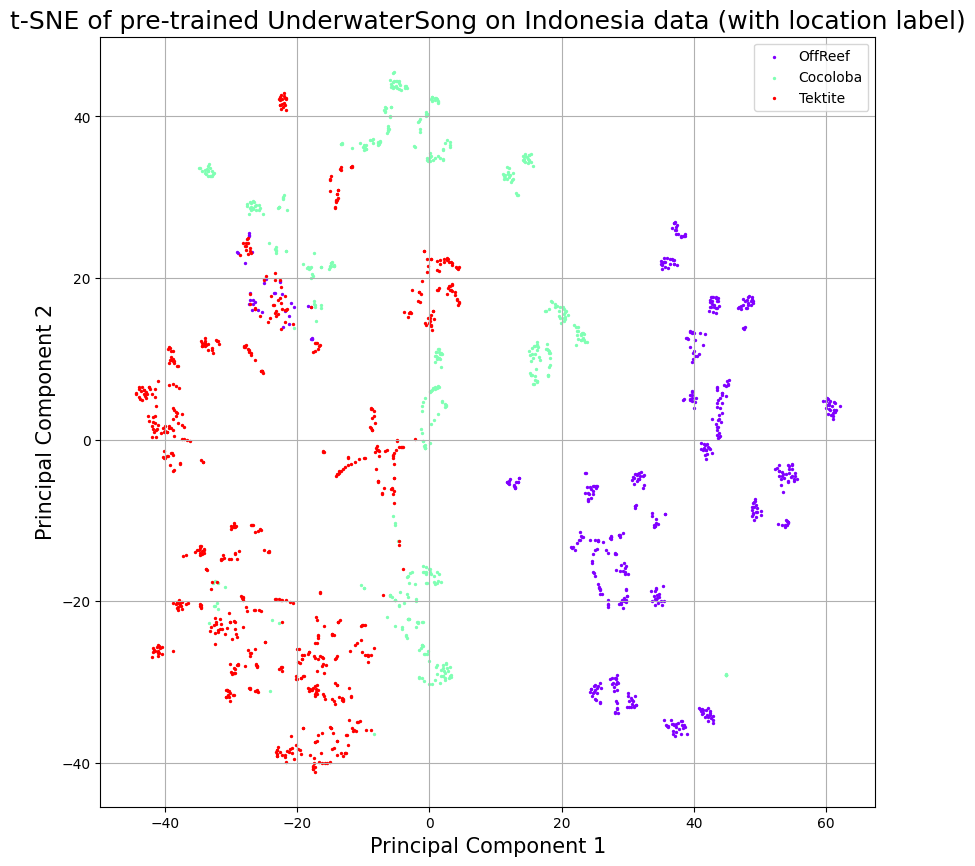

In [31]:
finalDf = pd.concat([principalDf, pd.Series(labels, name='label')], axis=1)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('t-SNE of pre-trained UnderwaterSong on Coral Chorus data', fontsize = 18)
# ax.set_title('t-SNE of pre-trained UnderwaterSong on Indonesia data (with coral health label)', fontsize = 18)
ax.set_title('t-SNE of pre-trained UnderwaterSong on Indonesia data (with location label)', fontsize = 18)
targets = [0, 1, 2]

cmap = plt.cm.get_cmap('rainbow', len(targets))
colors = [cmap(i) for i in range(len(targets))]
for target, color in tqdm(zip(targets,colors)):
    indicesToKeep = finalDf['label'] == target
    scat = ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 2)

# mean = np.mean(principalComponents0, axis=0)
# ax.plot(mean[0], mean[1], 'o', color='black', markersize=10)
ax.legend([label_dct[target] for target in targets])
ax.grid()

In [32]:
# fig.savefig('tsne_pretrained_coral_chorus.png')
# fig.savefig('tsne_pretrained_indo_health.png')
fig.savefig('tsne_pretrained_indo_loc.png')
